## Trabajo final módulo NLP

#### Clasificación multietiqueta de los tweets del archivo sem_eval_train.csv respecto a 11 sentimientos:
- anger
- anticipation
- disgust
- fear
- joy
- love
- optimism
- pessimism
- sadness
- surprise
- trust

#### Cada tweet puede pertenecer a varias clases

### En este notebook probaré un modelo sencillo usando una RNN para un clasificador Multi clase.

In [1]:
import pandas as pd
import re, string, spacy
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Embedding, SpatialDropout1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


2024-09-05 20:38:21.980396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 20:38:22.041388: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 20:38:22.043653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-05 20:38:22.043661: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc

In [2]:
RNN_DIM = 75
RNN_layer = GRU

In [3]:
df = pd.read_csv('sem_eval_train_es.csv', index_col='ID')

df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
ID,,,,,,,,,,,,
2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-Es-06340,Ahorita quisiera que mi preocupación más grand...,False,False,False,True,False,False,False,True,True,False,False
2018-Es-00439,El mayor criminal del país diciéndole “delincu...,True,False,True,False,False,False,False,False,False,False,False
2018-Es-04919,Mi prima de 4 años se ha enfadado conmigo porq...,True,False,False,False,False,False,False,False,False,True,False


In [4]:
nlp = spacy.load('es_core_news_md')

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation)))

def clean_text(text, lemas=False):
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text)
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens]
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [5]:
df.Tweet = df.Tweet.apply(clean_text, lemas = True)
df[df['Tweet'] != '']

label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
df[label_columns] = df[label_columns].astype(int)
Y = df[label_columns].values

# Separar los datos en entrenamiento y prueba
tweets_train, tweets_test, Y_train, Y_test = train_test_split(df.Tweet, Y, 
    test_size=0.2, random_state=0)

In [6]:
cv = CountVectorizer(min_df=2)
cv.fit(tweets_train)
max_features = len(cv.get_feature_names_out())
max_features

2003

In [7]:
MAX_NB_WORDS = max_features+2
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split = ' ', oov_token='OOV')
tokenizer.fit_on_texts(tweets_train.values)

X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

MAX_SEQUENCE_LENGTH = X_train.shape[1]
X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

Found 6378 unique tokens.


In [8]:
nlp = spacy.load('es_core_news_md')

EMBREDDING_DIM = nlp.vocab.vectors_length
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBREDDING_DIM))
vectores = 0

for word, i in word_index.items():
    if(i<MAX_NB_WORDS):
        if nlp.vocab[word].has_vector:
            embedding_matrix[i] = nlp.vocab[word].vector
            vectores += 1

In [14]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBREDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable = False,
                            mask_zero = True)

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.5))
model.add(GRU(300, dropout=0.45, recurrent_dropout=0.45, return_sequences=True))
model.add(GRU(200, dropout=0.45, recurrent_dropout=0.45, return_sequences=True))
model.add(GRU(100, dropout=0.45, recurrent_dropout=0.45))
model.add(Dense(11, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 300)           601500    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 32, 300)          0         
 lDropout1D)                                                     
                                                                 
 gru_3 (GRU)                 (None, 32, 250)           414000    
                                                                 
 gru_4 (GRU)                 (None, 32, 125)           141375    
                                                                 
 gru_5 (GRU)                 (None, 75)                45450     
                                                                 
 dense_1 (Dense)             (None, 11)                836       
                                                      

In [15]:
batch_size = 64
epochs = 100
filepath='weights.best.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=0)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max', restore_best_weights=False)

callbacks_list = [checkpoint, reduce_lr, early_stopping]
history = model.fit(X_train, Y_train, epochs=100,
                    batch_size=batch_size, verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks = callbacks_list)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.2651
Epoch 1: val_accuracy improved from -inf to 0.39271, saving model to weights.best.hdf5
45/45 [==============================] - 6s 75ms/step - loss: 0.4428 - accuracy: 0.2651 - val_loss: 0.4031 - val_accuracy: 0.3927 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.3508
Epoch 2: val_accuracy improved from 0.39271 to 0.39551, saving model to weights.best.hdf5
45/45 [==============================] - 3s 68ms/step - loss: 0.3952 - accuracy: 0.3508 - val_loss: 0.3962 - val_accuracy: 0.3955 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.3648
Epoch 3: val_accuracy improved from 0.39551 to 0.41795, saving model to weights.best.hdf5
45/45 [==============================] - 3s 67ms/step - loss: 0.3899 - accuracy: 0.3648 - val_loss: 0.3905 - val_accuracy: 0.4180 - lr: 0.0010
Epoch 4/100
45/45 [

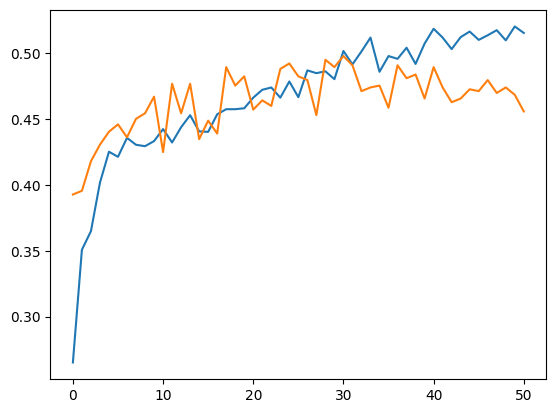

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [17]:
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size=batch_size)

print('score: %.2f' % (score))
print('acc: %.2f' % (acc))

12/12 - 0s - loss: 0.3388 - accuracy: 0.4558 - 179ms/epoch - 15ms/step
score: 0.34
acc: 0.46


In [18]:
predict = model.predict(X_test, batch_size = 1)
prediccion = (predict>0.5).astype(int)

target_names = [
    "anger", "anticipation", "disgust", "fear",
    "joy", "love", "optimism", "pessimism",
    "sadness", "surprise", "trust"
]
from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=target_names))

433/713 [=================>............] - ETA: 1s